In [1]:
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiplicativeLR, CyclicLR, LambdaLR
from stepbystep.v2 import StepByStep
from data_generation.rps import download_rps

In [2]:
# This may take a couple of minutes...
download_rps()

In [3]:
temp_transform = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)

In [4]:
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

In [5]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [10]:
@staticmethod
def statistics_per_channel(images, labels):
    # NCHW
    n_samples, n_channels, n_height, n_weight = images.size()
    # Flatten HW into a single dimension
    flatten_per_channel = images.reshape(n_samples, n_channels, -1)
    means = flatten_per_channel.mean(axis=2)
    stds = flatten_per_channel.std(axis=2)

    # Adds up statistics of all images in a mini-batch
    # (1, n_channels)
    sum_means = means.sum(axis=0)
    sum_stds = stds.sum(axis=0)
    n_samples = torch.tensor([n_samples] * n_channels).float()

    # Stack the thress tensors on top of one anthor
    # (3, n_channels)
    return torch.stack([n_samples, sum_means, sum_stds], axis=0)

setattr(StepByStep, 'statistics_per_channel', statistics_per_channel)

In [11]:
first_iamges, first_labels = next(iter(temp_loader))
StepByStep.statistics_per_channel(first_iamges, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

In [13]:
results = StepByStep.loader_apply(temp_loader,StepByStep.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

In [14]:
@staticmethod
def make_normalizer(loader):
    total_samples, total_means, total_stds = StepByStep.loader_apply(loader, StepByStep.statistics_per_channel)
    norm_mean = total_means / total_samples
    norm_std = total_stds / total_samples
    return Normalize(mean=norm_mean, std=norm_std)

setattr(StepByStep, 'make_normalizer', make_normalizer)

In [15]:
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

In [16]:
composer = Compose([Resize(28),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

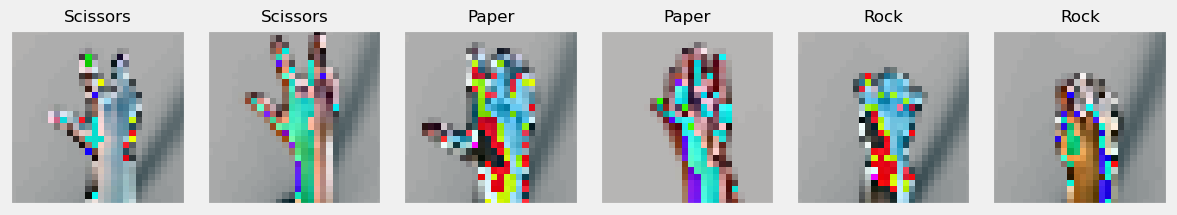

In [19]:
from plots.chapter6 import *
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

In [20]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50) 
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)
        
    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x
    
    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x
                
    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

In [22]:
torch.manual_seed(13)
model_cnn2 = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

In [23]:
sbs_cnn2 = StepByStep(model_cnn2, multi_loss_fn, optimizer_cnn2)
sbs_cnn2.set_loaders(train_loader, val_loader)
sbs_cnn2.train(10)

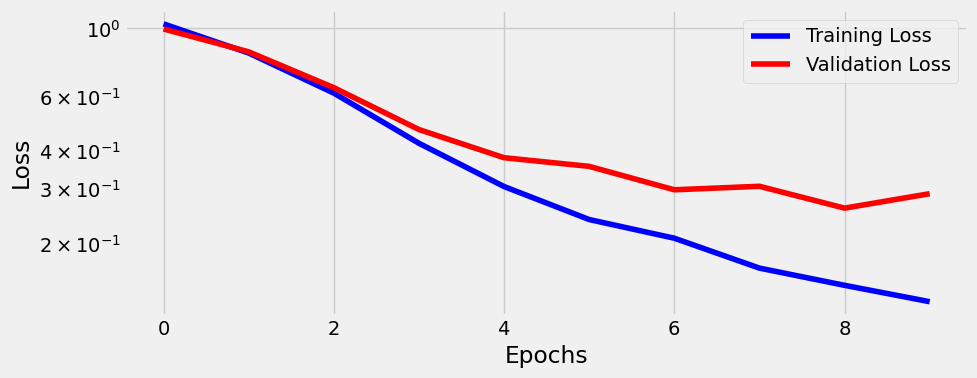

In [24]:
fig = sbs_cnn2.plot_losses()

In [28]:
StepByStep.loader_apply(val_loader, sbs_cnn2.correct)

tensor([[ 93, 124],
        [119, 124],
        [114, 124]])